# 3D Face Texture Generator

* 의의: 2D 입력 이미지로부터 UV Texture를 추출할 때 발생하는 self-occlusion 문제를 개선하기 위함

* 프로세스 요약:

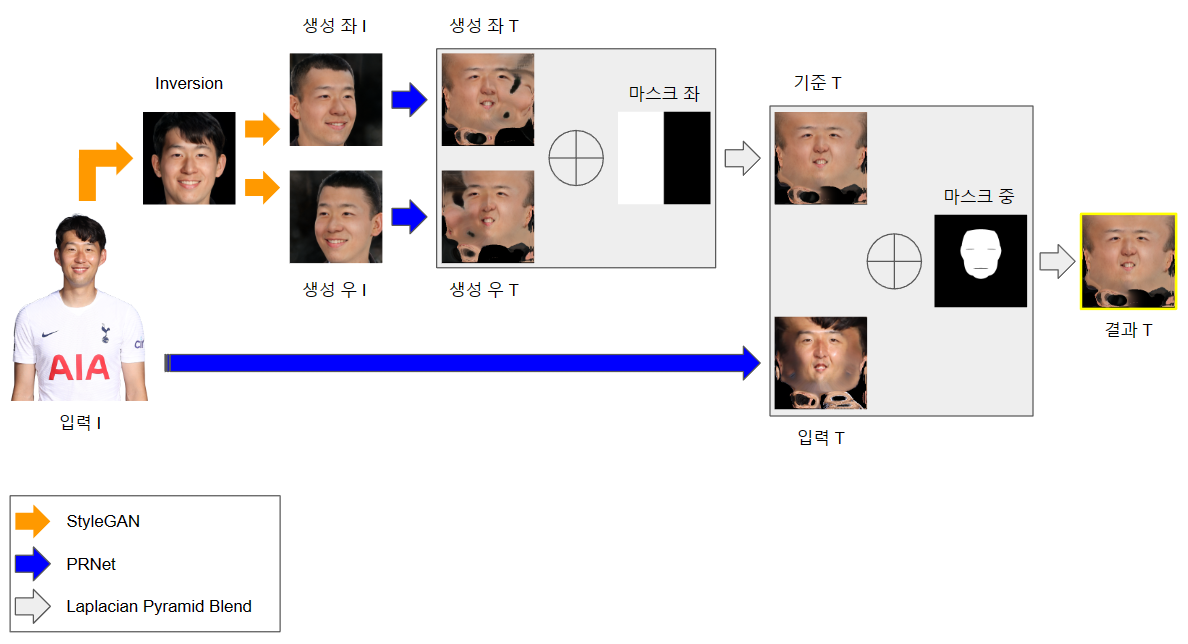
1) <입력 이미지>로부터 얼굴의 좌/우측면이 온전히 노출된 이미지를 각각 생성한다. (StyleGAN)
2) 생성 이미지 2장 및 입력 이미지에 대한 UV Texture를 각각 추출한다. (PRNet)
3) <생성 이미지 좌>로부터 추출된 UV Texture의 수직 중앙선 기준 좌측 영역을 마스킹하여 <생성 이미지 우>의 UV Texture와 합성한다. --> <기준 Template> (Laplacian Pyramid Blend)
4) <입력 이미지>로부터 추출된 UV Texture에서 self-occlusion 발생 영역을 제외한 얼굴의 중앙을 마스킹하여 '3)'의 <기준 Template>과 합성한다. (Laplacian Pyramid Blend)

---

----------------- Options ---------------
          camera_distance: 10.0                          
                   device: cuda:0                        
           dpr_model_path: checkpoints/dpr_model/trained_model_03.t7
           e4e_model_path: checkpoints/e4e_model/e4e_ffhq_encode.pt
               edit_items: delight,norm_attr,multi_yaw   
          flow_model_path: checkpoints/styleflow_model/modellarge10k.pt
                    focal: 1015.0                        
                input_dir: inputs                        
              network_pkl: checkpoints/stylegan_model/stylegan2-ffhq-config-f.pkl
               output_dir: outputs                       
                    phase: test                          
         prnet_model_path: checkpoints/prnet_model/256_256_resfcn256_weight
shape_predictor_model_path: checkpoints/dlib_model/shape_predictor_68_face_landmarks.dat
----------------- End -------------------


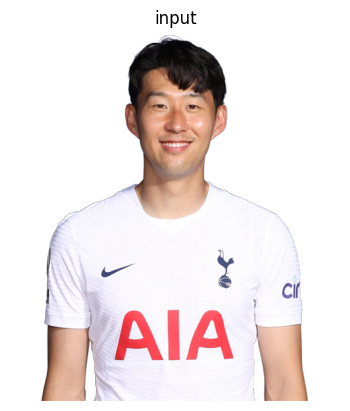

In [1]:
import os
from matplotlib import pyplot as plt
from test_options import TestOptions

def show_result(img_path, title=""):
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

resolution = 256
args = TestOptions().parse()
args.input_fnames = [fn for fn in sorted(os.listdir(args.input_dir)) if fn.endswith('.jpg') or fn.endswith('.png') or fn.endswith('.jpeg')]

for fn in args.input_fnames:
    img_path = os.path.join(args.input_dir, fn)
    show_result(img_path, 'input')
    plt.show()

## 1. 이미지 생성

* Inversion

Loading e4e over the pSp framework from checkpoint: checkpoints/e4e_model/e4e_ffhq_encode.pt
Inverse son.png took 3.7285 seconds.
Inversion process done!


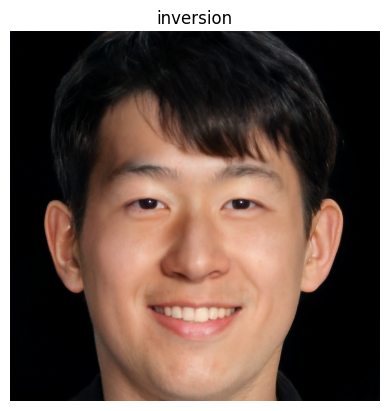

In [2]:
from inversion.e4e_inverter import inversion

inversion(args)

for fn in args.input_fnames:
    fn_inversion = fn.replace('.png', '_inverted.png')
    img_path = f'inversion/results/{fn_inversion}'
    show_result(img_path, 'inversion')
    plt.show()

* Editing

DPR model successfully loaded from checkpoints/dpr_model/trained_model_03.t7!
Calculate light son_inverted.png took 0.1984 seconds.
Calculate light Done!
Loading networks from "checkpoints/stylegan_model/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Training T : 1.0
Number of trainable parameters of Point CNF: 1691649
Editing son.png took 8.1575 seconds.


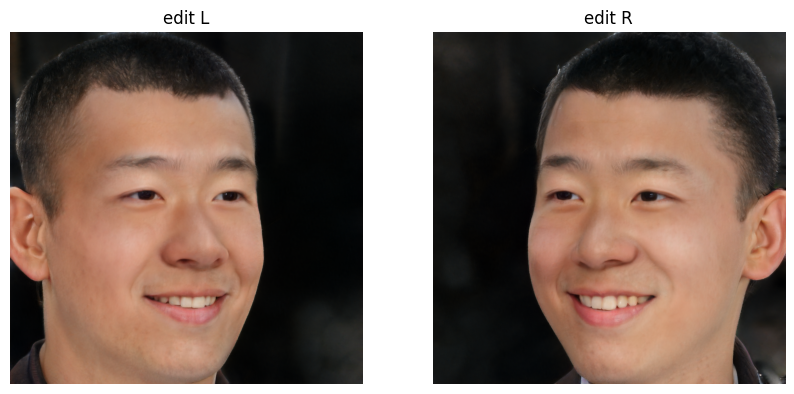

In [3]:
from editing.editor import editing

editing(args)

for fn in args.input_fnames:
    fn_left = fn.replace('.png', '_left.png')
    img_path = f'editing/results/{fn_left}'
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    show_result(img_path, 'edit L')
    fn_right = fn.replace('.png', '_right.png')
    img_path = f'editing/results/{fn_right}'
    plt.subplot(1,2,2)
    show_result(img_path, 'edit R')
    plt.show()

## 2. UV Texture 추출

* PRNet

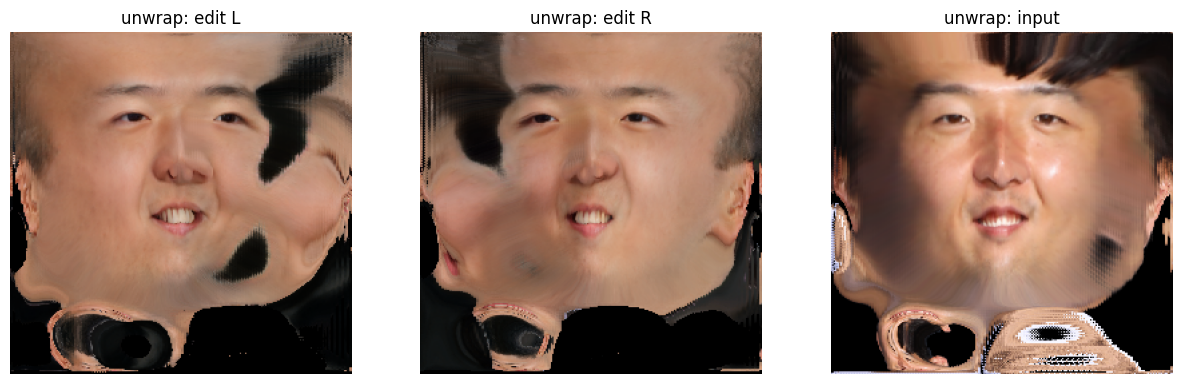

In [4]:
from unwrap.unwrapper import unwrapping

unwrapping(args, resolution)

for fn in args.input_fnames:
    fn_left_tex = fn.replace('.png', '_left_tex.png')
    img_path = f'unwrap/results/{fn_left_tex}'
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    show_result(img_path, 'unwrap: edit L')
    fn_right_tex = fn.replace('.png', '_right_tex.png')
    img_path = f'unwrap/results/{fn_right_tex}'
    plt.subplot(1,3,2)
    show_result(img_path, 'unwrap: edit R')
    fn_tex = fn.replace('.png', '_tex.png')
    img_path = f'unwrap/results/{fn_tex}'
    plt.subplot(1,3,3)
    show_result(img_path, 'unwrap: input')
    plt.show()

## 3. UV Texture 합성

* Laplacian Pyramid Blend

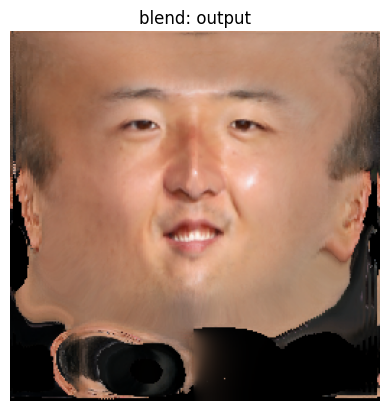

In [5]:
from blend.blender import blending

blending(args, resolution)

for fn in args.input_fnames:
    dirname = os.path.splitext(fn)[0]
    img_path = f'outputs/{dirname}/texture.png'
    show_result(img_path, 'blend: output')
    plt.show()

## 3. 결과 확인

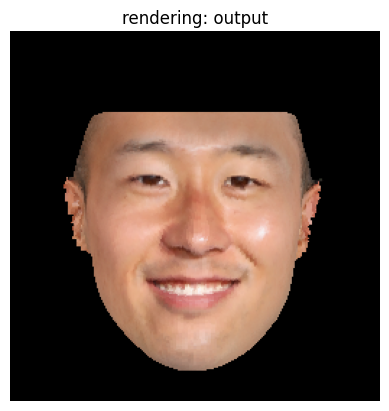

In [6]:
import numpy as np
import mesh

for fn in args.input_fnames:
    dirname = os.path.splitext(fn)[0]
    
    vertices = np.load(os.path.join(args.output_dir, dirname, 'vertices.npy'))
    triangles = np.load(os.path.join(args.output_dir, dirname, 'triangles.npy'))
    uv_coords = np.load(os.path.join(args.output_dir, dirname, 'uvcoords.npy'))
    uv_texture = plt.imread(os.path.join(args.output_dir, dirname, 'texture.png'))
    
    # transform
    vertices = vertices - np.mean(vertices, 0)[np.newaxis, :]
    s = 180/(np.max(vertices[:,1]) - np.min(vertices[:,1]))
    R = mesh.transform.angle2matrix([0, 0, 0]) 
    t = [0, 0, 0]
    vertices = mesh.transform.similarity_transform(vertices, s, R, t)
    image_vertices = mesh.transform.to_image(vertices, resolution, resolution)

    rendering = mesh.render.render_texture(image_vertices, triangles, uv_texture, uv_coords, triangles, resolution, resolution)
    plt.imshow(rendering)
    plt.title('rendering: output')
    plt.axis('off')
    plt.show()